In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

## Загружаем данные

Выбираем только интермедиаты и агенты

In [2]:
df = pd.read_table('/home/jupyter/datasphere/project/reaction_preparation.tsv')
df = df.iloc[:, :-1]
df.head()

,interm_0,interm_1,interm_2,interm_3,interm_4,interm_5,interm_6,interm_7,interm_8,interm_9,agents_0,agents_1,agents_2
0,O[C:12]1([CH2:13][C:14](=[O:15])[O:16][CH2:17]...,Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CCO,NaN,NaN
1,CC[O:16][C:14]([CH:13]=[C:12]1[C:6]2=[C:7]([N:...,[OH-],[K+],Cl,NaN,NaN,NaN,NaN,NaN,NaN,CCO,NaN,NaN
2,[H-],[Al+3],[Li+],[H-],[H-],[H-],O=[C:20]([CH2:19][C:18]1=[CH:17][C:16]2=[C:15]...,CCOC(C)=O,[OH-],[Na+],C1CCOC1,NaN,NaN
3,[NH2:1][C:2]1=[CH:13][C:6]2=[C:5]([CH:4]=[CH:3...,CC(=O)O[C:14]([CH3:15])=[O:16],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C1=CC=CC=C1,NaN,NaN
4,[C:1]([CH3:2])([CH3:3])([CH3:4])[NH:5][NH:6][C...,ClCCl,BrBr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O,NaN,NaN


## Для того чтобы не считать одно и тоже для одинаковых соединений, просто выделим все уникальные молекулы

In [3]:
uniq_mol = set()

for col in df.columns:
    uniq_mol = uniq_mol.union(set(df[col]))

uniq_mol = list(uniq_mol)
    
len(uniq_mol)

870901

Уберём разницу в порядке нумирации атомов

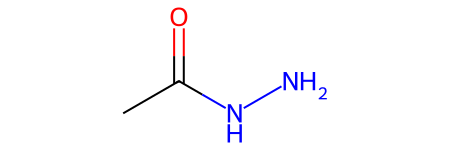

In [4]:
import re

def remove_numbers_after_colon(text):
    return re.sub(r':[0-9]+', '', text)

text = 'O=[C:15]([CH3:16])[NH:18][NH2:19]'
result = remove_numbers_after_colon(text)
Chem.MolFromSmiles(result)

In [5]:
mol_prepare_smiles = []

for mol in tqdm(uniq_mol):
    try:
        mol_prepare_smiles.append(remove_numbers_after_colon(mol))
    except:
        mol_prepare_smiles.append(None)

map_mol = pd.DataFrame(zip(uniq_mol, mol_prepare_smiles), columns = ['mol', 'prepare_mol'])
map_mol.head()

100%|██████████| 870901/870901 [00:04<00:00, 210784.55it/s]


,mol,prepare_mol
0,O=[N+:22]([O-])[C:25]1=[C:26]([Cl:34])[C:27]([...,O=[N+]([O-])[C]1=[C]([Cl])[C]([Cl])=N[C]([Cl])...
1,C[Si-](C)(C)(F)F,C[Si-](C)(C)(F)F
2,OC(=O)C1=CN2C=C(C(F)(F)F)[CH:19]=[C:14](Cl)[C:...,OC(=O)C1=CN2C=C(C(F)(F)F)[CH]=[C](Cl)[C]2=N1
3,CC1(C)[N:19]([C:24]([CH:25]([F:26])[F:27])=[O:...,CC1(C)[N]([C]([CH]([F])[F])=[O])[C@H]([CH2][F]...
4,[CH2:1]([CH2:2][CH2:3][CH2:4][CH2:5][CH3:6])[C...,[CH2]([CH2][CH2][CH2][CH2][CH3])[C]1=[C]([CH]=...


Количество уникальных значений в маппере

In [6]:
map_mol.mol.nunique(), map_mol.prepare_mol.nunique()

(870900, 621549)

## Удалим молекулы, которые не переводятся в Smiles

In [21]:
drop_index = []

for ind, mol in enumerate(map_mol.prepare_mol):
    try:
        Chem.MolToSmiles(Chem.MolFromSmiles(mol))
    except:
        drop_index.append(ind)

map_mol = map_mol.drop(drop_index, axis = 0).reset_index(drop = True)

[13:25:30] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[13:25:32] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[13:25:32] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[13:25:33] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[13:25:34] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[13:25:37] Explicit valence for atom # 7 Cl, 3, is greater than permitted
[13:25:39] Explicit valence for atom # 3 Cl, 3, is greater than permitted
[13:25:39] Explicit valence for atom # 0 Cl, 7, is greater than permitted
[13:25:41] Explicit valence for atom # 1 Br, 3, is greater than permitted
[13:25:43] Explicit valence for atom # 1 Br, 3, is greater than permitted
[13:25:45] Explicit valence for atom # 0 N, 5, is greater than permitted
[13:25:45] Explicit valence for atom # 1 Br, 3, is greater than permitted
[13:25:46] Explicit valence for atom # 0 H, 2, is greater than permitted
[13:25:46] WARNING: not removing hydroge

In [22]:
map_mol.head()

,mol,prepare_mol
0,O=[N+:22]([O-])[C:25]1=[C:26]([Cl:34])[C:27]([...,O=[N+]([O-])[C]1=[C]([Cl])[C]([Cl])=N[C]([Cl])...
1,C[Si-](C)(C)(F)F,C[Si-](C)(C)(F)F
2,OC(=O)C1=CN2C=C(C(F)(F)F)[CH:19]=[C:14](Cl)[C:...,OC(=O)C1=CN2C=C(C(F)(F)F)[CH]=[C](Cl)[C]2=N1
3,CC1(C)[N:19]([C:24]([CH:25]([F:26])[F:27])=[O:...,CC1(C)[N]([C]([CH]([F])[F])=[O])[C@H]([CH2][F]...
4,[CH2:1]([CH2:2][CH2:3][CH2:4][CH2:5][CH3:6])[C...,[CH2]([CH2][CH2][CH2][CH2][CH3])[C]1=[C]([CH]=...


In [23]:
map_mol.shape

(870765, 2)

## Сохраняем маппер для будущих расчётов

In [24]:
map_mol.to_csv('./mapper_moleculares.tsv', index = 0, sep = '\t')